In [1]:
import sys
import os

module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import choose_day_number, search_best_params, predict_best_model, create_x_y_datasets

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

***NB! All data is located in S3 cloud, which is connected with dvc. If you want to reproduce experiments you should clone repo, intall packeges with poetry, and run dvc pull to get actual data***

## Task

The task of this project is to predict Air Quality Index for tomorrow (in future for several day ahead). It is important goal because forecasts helps people who are sensitive to air pollution to plan ahead to protect their health.

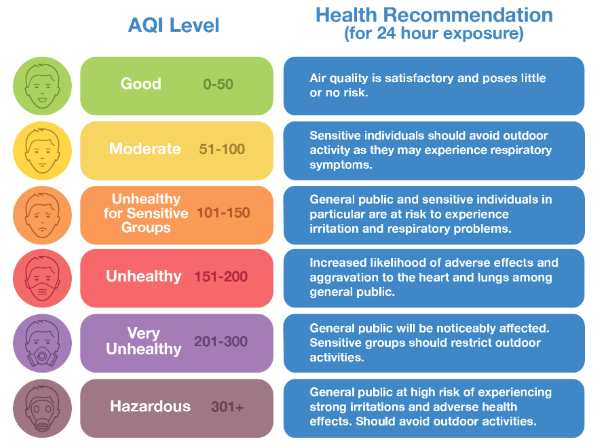

Data was loaded from http://discomap.eea.europa.eu/. One part is historical data, where date, country and pollutants can be chosen. Second part is up-to-date data, which contain 48 last hours. **The big goal of this project is to update data and make prediction.**

Data is checked by testing, because it is not very clean. Possible mistakes change in preprocessing script, new mistakes will call assert in tests.

Forecasting locations were chosen based on the availability of air quality monitoring data. In our case Spain is the best country with long-story-data with several stations without gaps.

For calculation AQI we use ozone, SO2, NO2, CO, and PM10, PM2.5. The last ones are airborne particulate matter (PM). Those with a diameter of 10 microns or less (PM10) are inhalable into the lungs and can induce adverse health effects. Fine particulate matter is defined as particles that are 2.5 microns or less in diameter (PM2.5). Therefore, PM2.5 comprises a portion of PM10.

### Pollutants

In this section we can see polluntants plots and check outliers, if any. We check outliers without boxplot because large pollutants values are often cause of large AQI value.

In [30]:
country = 'ES'

In [31]:
df_co = pd.read_csv(f"../data/interim/cleaned/{country}_CO_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
df_co

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,SamplingProcess,Sample,AirPollutant,AirPollutantCode,AveragingTime,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
Datetime,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.7,mg/m3,2020-01-01 00:00:00 +01:00,2020-01-01 01:00:00 +01:00,1,1
2020-01-01 02:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.9,mg/m3,2020-01-01 01:00:00 +01:00,2020-01-01 02:00:00 +01:00,1,1
2020-01-01 03:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.8,mg/m3,2020-01-01 02:00:00 +01:00,2020-01-01 03:00:00 +01:00,1,1
2020-01-01 04:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.6,mg/m3,2020-01-01 03:00:00 +01:00,2020-01-01 04:00:00 +01:00,1,1
2020-01-01 05:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.6,mg/m3,2020-01-01 04:00:00 +01:00,2020-01-01 05:00:00 +01:00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29 00:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.4,mg/m3,2022-05-28 23:00:00 +01:00,2022-05-29 00:00:00 +01:00,1,3
2022-05-29 01:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.2,mg/m3,2022-05-29 00:00:00 +01:00,2022-05-29 01:00:00 +01:00,1,3
2022-05-29 02:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,STA_ES1563A,ES1563A,SP_28005002_6_48,SPP_28005002_6_48.1,SAM_28005002_6_48,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.2,mg/m3,2022-05-29 01:00:00 +01:00,2022-05-29 02:00:00 +01:00,1,3


<AxesSubplot:xlabel='Datetime'>

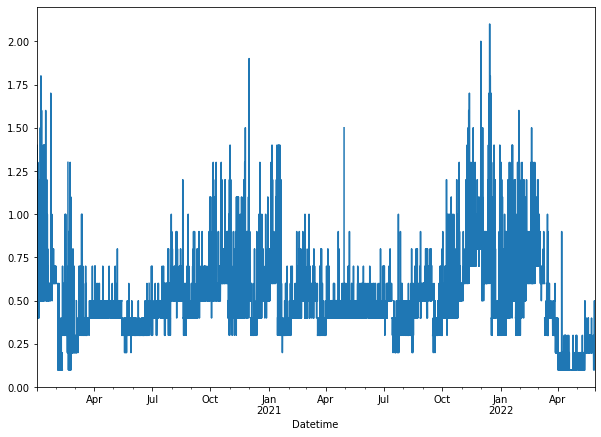

In [32]:
fig = plt.figure(figsize=(10, 7))
df_co["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

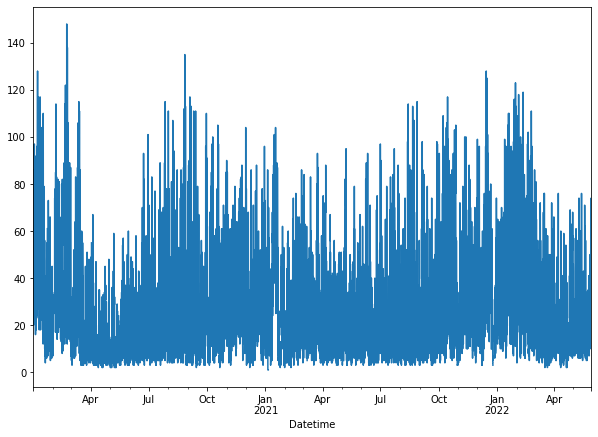

In [33]:
df_no2 = pd.read_csv(f"../data/interim/cleaned/{country}_NO2_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(10, 7))
df_no2["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

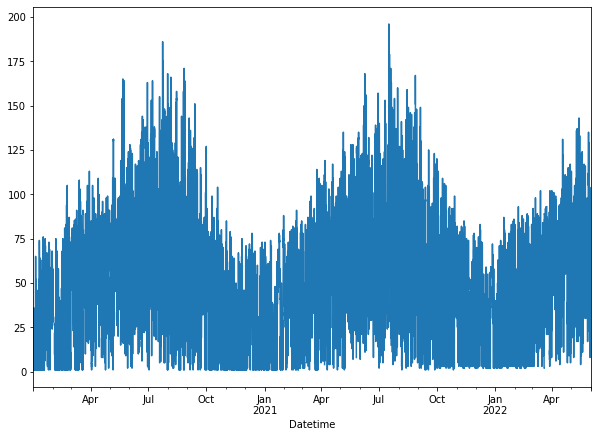

In [34]:
df_o3 = pd.read_csv(f"../data/interim/cleaned/{country}_O3_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(10, 7))
df_o3["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

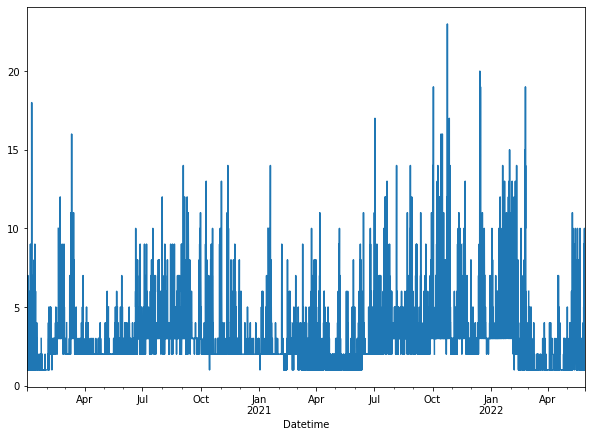

In [35]:
df_so2 = pd.read_csv(f"../data/interim/cleaned/{country}_SO2_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(10, 7))
df_so2["Concentration"].plot()

There are many big values for PM10 and PM2.5. But we have to remember that its values can be above 500.

<AxesSubplot:xlabel='Datetime'>

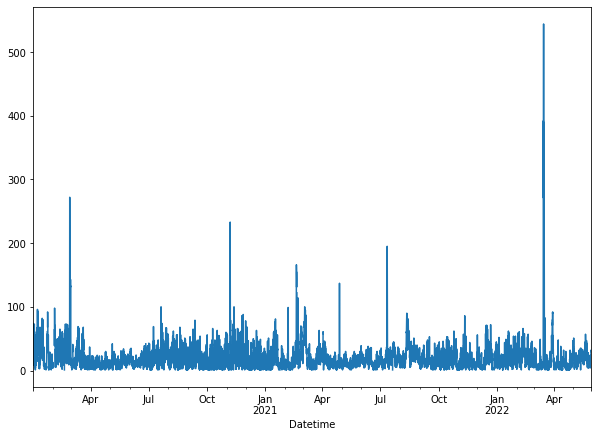

In [14]:
df_pm10 = pd.read_csv(f"../data/interim/cleaned/{country}_PM10_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(10, 7))
df_pm10["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

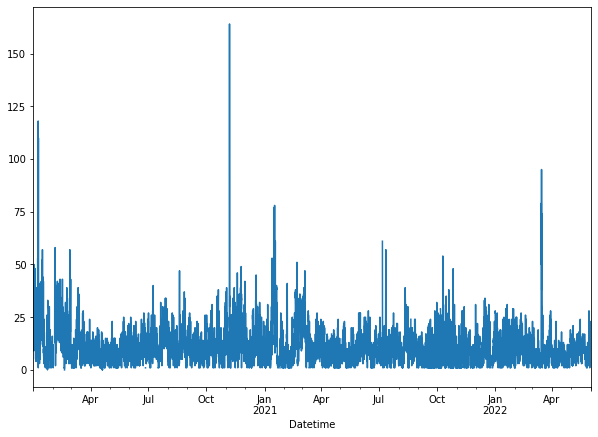

In [36]:
df_pm25 = pd.read_csv(f"../data/interim/cleaned/{country}_PM2.5_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(10, 7))
df_pm25["Concentration"].plot()

Values for PM10 refer to PM2.5 values, this follows from PM definitions (particulate matter). So let's check if one pollutant has large value, whether the values of another pollutant are also large. Most often PM10 depends on PM2.5 more than PM2.5 on PM10.

In [28]:
df_pm25["Concentration"].max(), df_pm10.loc[df_pm25["Concentration"].idxmax(), "Concentration"]

(164.0, 230.0)

In [27]:
df_pm10["Concentration"].max(), df_pm25.loc[df_pm10["Concentration"].idxmax(), "Concentration"]

(544.0, 95.0)

### AQI

AQI - air quality index is the highest value calculated for each pollutant. For polutants are calculated subindex and then we choose the biggest one (see references in repo about calculation AQI).

It's AQI for 1 hour

<AxesSubplot:xlabel='Datetime'>

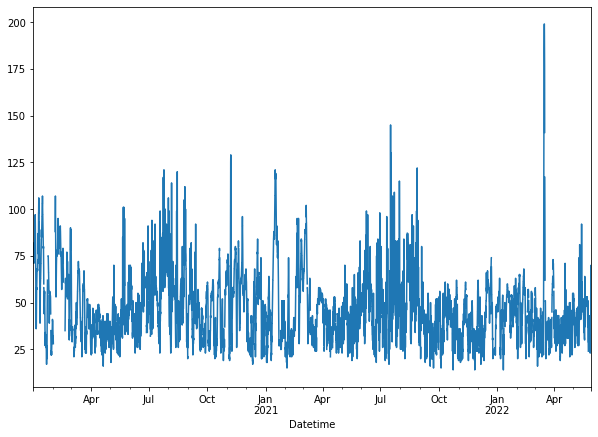

In [3]:
df_aqi = pd.read_csv("../data/processed/AQI_dataset.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(10, 7))
df_aqi["AQI"].plot()

We use daily AQI

<AxesSubplot:xlabel='Datetime'>

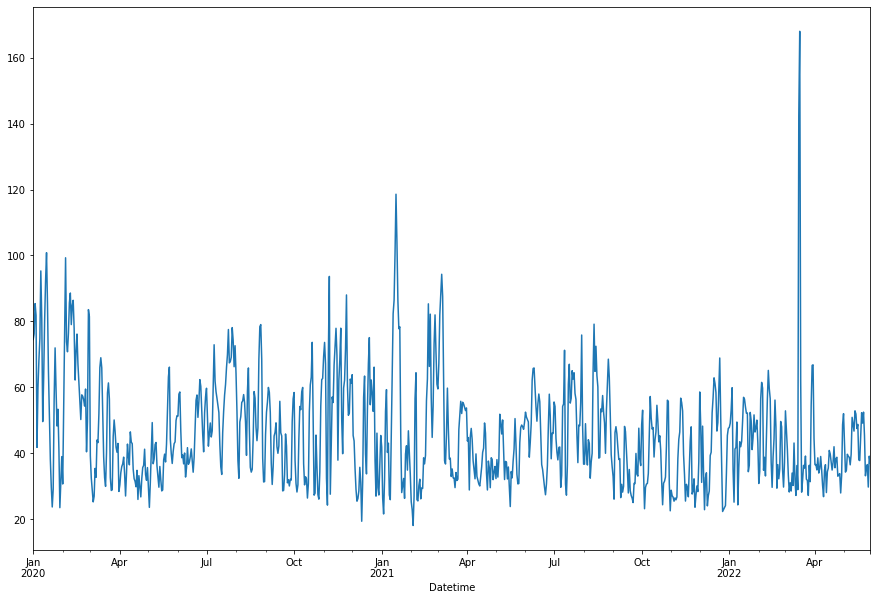

In [4]:
df_aqi_daily = df_aqi.resample('D').mean().interpolate()
fig = plt.figure(figsize=(15, 10))
df_aqi_daily["AQI"].plot()

Here there is AQI distribution. It does not contradict our knowledge of this country, most of values are not very big, but we have a heavy tail with rare large values.

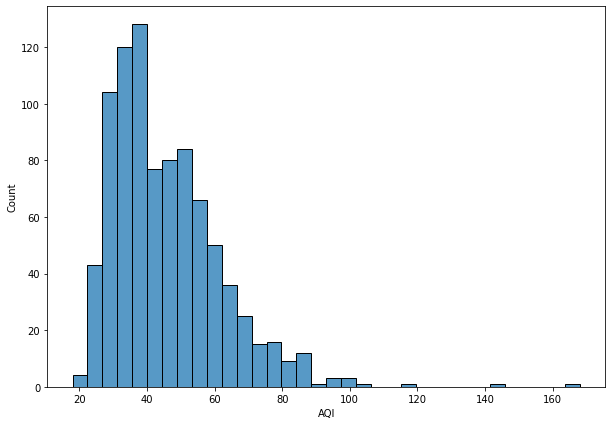

In [30]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(df_aqi_daily["AQI"],);

***Time series analysis***

First we have to check classic time series model. For choosing correct model let's check propeties of AQI as series.

Stationarity

In [35]:
ADF_result = adfuller(df_aqi_daily["AQI"])   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.869053097432937
p-value: 1.383425557559172e-19


With a large negative ADF statistic and a p-value much smaller than 0.05, we can say that our series is stationary.

Autocorrelation

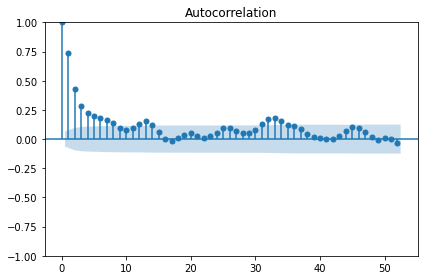

In [130]:
plot_acf(df_aqi_daily["AQI"], lags=52)
plt.tight_layout()

C:\Users\nikit\AppData\Local\pypoetry\Cache\virtualenvs\mlops-project-yU0lcWq_-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


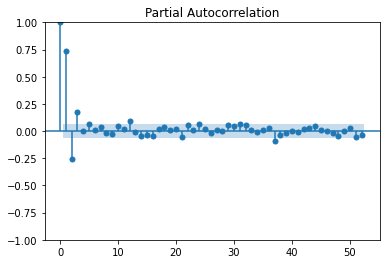

In [124]:
plot_pacf(df_aqi_daily["AQI"], lags=52)
plt.show()

Looks like autoregressive process 

<AxesSubplot:xlabel='Datetime'>

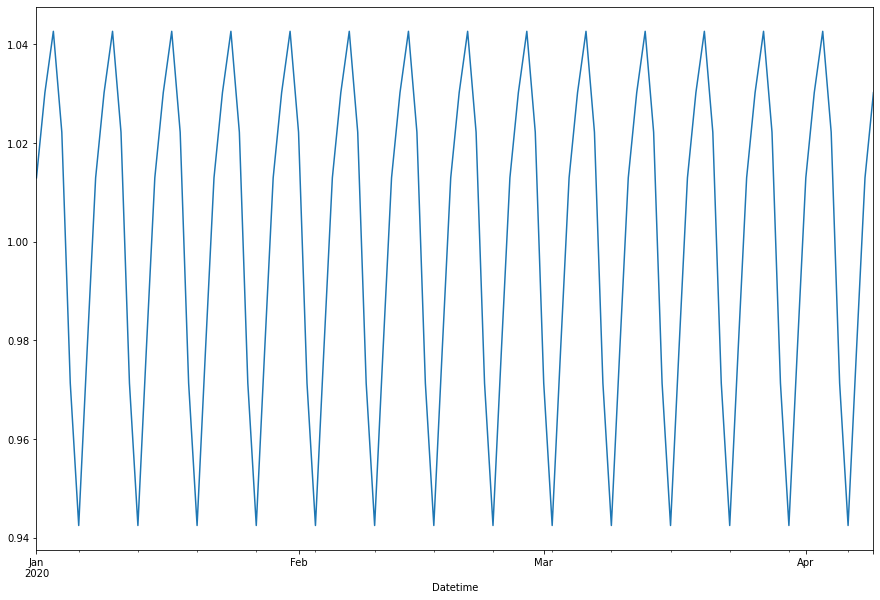

In [20]:
analysis = df_aqi_daily["AQI"].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = plt.figure(figsize=(15, 10))
seasonal[:100].plot()

Looks like there is weekly seasonality

In [10]:
print("Mean: ", df_aqi_daily["AQI"].mean(), "\nSTD: ", df_aqi_daily["AQI"].std(), "\nMedian: ", df_aqi_daily["AQI"].median())

Mean:  45.828011182759425 
STD:  16.238174670153402 
Median:  42.62280701754386


### ***Baseline Naive Algorithm***

For confidance that we will choose best model we check errors for most naive model: tommorow wil be as today. 

In [115]:
pd.concat([df_aqi_daily["AQI"].shift(1), df_aqi_daily["AQI"]], axis=1).dropna()
values = pd.DataFrame(df_aqi_daily["AQI"].values)
df_naive = pd.concat([values.shift(1), values], axis=1).dropna()
df_naive.columns = ['t', 't+1']
df_naive

,t,t+1
1,74.500000,76.208333
2,76.208333,85.375000
3,85.375000,81.791667
4,81.791667,41.708333
5,41.708333,59.916667
...,...,...
875,33.090909,35.500000
876,35.500000,36.500000
877,36.500000,29.666667
878,29.666667,39.045455


Now we don't predict several days, but for 25% test size "every day prediction" we have errors aboy 14 for RMSE, and abot 8 MAE 

In [118]:
train_size = int(df_naive.shape[0] * 0.75)
train, test = df_naive[1:train_size], df_naive[train_size:]
train_X, train_y = train["t"], train["t+1"]
test_X, test_y = test["t"], test["t+1"]

In [119]:
predictions = test_X.apply(lambda x: x)
test_rmse = mean_squared_error(test_y, predictions, squared=False)
test_mae = mean_absolute_error(test_y, predictions)
print("Test RMSE: %.3f" % test_rmse, "\nTest MAE: %.3f" % test_mae)

Test RMSE: 13.838 
Test MAE: 7.710


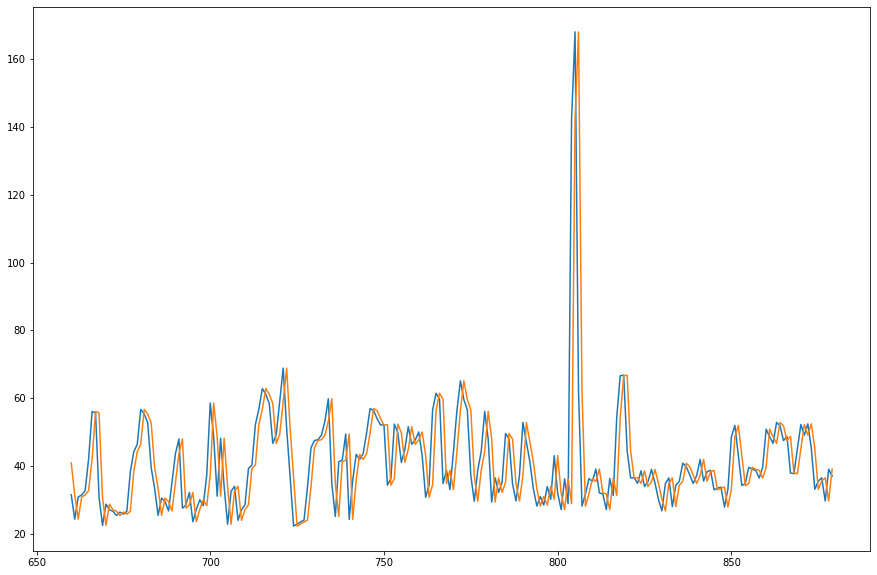

In [120]:
fig = plt.figure(figsize=(15, 10))
plt.plot(test_y.iloc[:])
plt.plot(predictions[:])
plt.show()

### ***AUTO ARIMA***

Because of seasonality we can choose seasonal ARIMA model, but from ACF and PACF it is complicated to choose parameters, let's try auto arima model.

In [201]:
train, test = train_test_split(df_aqi_daily["AQI"], test_size=0.25, shuffle=False) 

In [129]:
model = auto_arima(train, 
                   seasonal=True, 
                   m=52,
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=4919.310, Time=22.53 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=5556.695, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4961.876, Time=9.42 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=5098.069, Time=4.87 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7042.622, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=4915.507, Time=18.65 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=4914.315, Time=0.74 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=4916.016, Time=20.51 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=4917.371, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=4917.657, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[52] intercept   : AIC=4914.967, Time=0.79 sec
 ARIMA(2,0,3)(0,0,0)[52] intercept   : AIC=4915.006, Time=0.87 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=4915.992, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[52] intercept   : AIC=4914.333, Time=0.43 sec
 ARIMA(3,0,1)(0,

In [128]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  660
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -2451.739
Date:                Thu, 07 Jul 2022   AIC                           4913.478
Time:                        10:48:54   BIC                           4935.939
Sample:                             0   HQIC                          4922.184
                                - 660                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.2769      1.476      7.643      0.000       8.385      14.169
ar.L1          0.9878      0.032     31.327      0.000       0.926       1.050
ar.L2         -0.3784      0.039     -9.591      0.000      -0.456      -0.301
ar.L3          0.1534      0.030      5.038      0.000       0.094       0.213
sigma2        98.4928      4.373     22.521      0.000      89.921     107.065
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               123.31
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.09
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA can predict several days, but for comparison with other models, we will predict only one day ahead

In [202]:
predictions_sarima = []

for i in range(len(test)):
    model = SARIMAX(train, order=(3,0,0), seasonal_order=(0,0,0,52))
    model_fit = model.fit()
    predictions_sarima.append(model_fit.predict(start=len(train), end=len(train)))

    train = pd.concat([train, test[i:i+1]])
    

In [203]:
arima_test_rmse = mean_squared_error(test.iloc[:], pd.concat(predictions_sarima), squared=False)
arima_test_mae = mean_absolute_error(test.iloc[:], pd.concat(predictions_sarima))
print("Test RMSE: %.3f" % arima_test_rmse, "\nTest MAE: %.3f" % arima_test_mae)

Test RMSE: 12.758 
Test MAE: 7.426


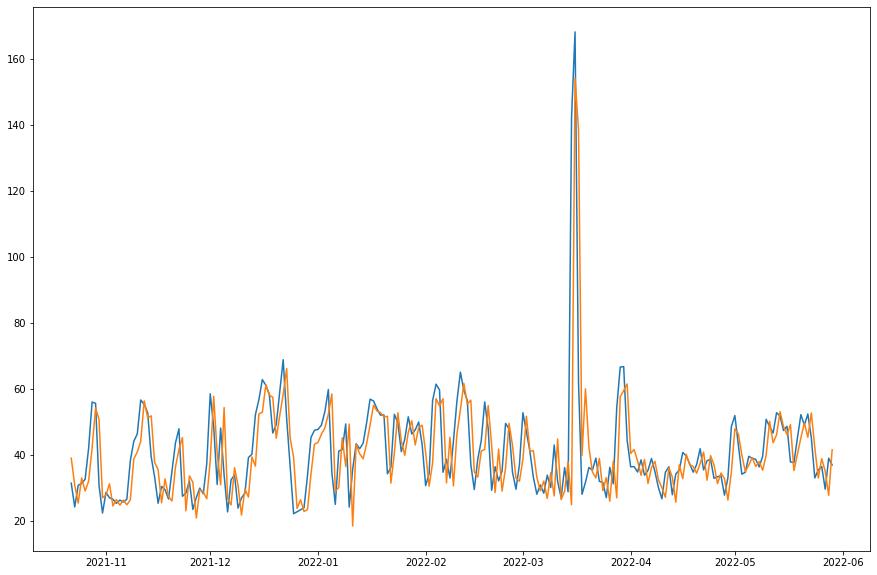

In [192]:
fig = plt.figure(figsize=(15, 10))
plt.plot(test)
plt.plot(pd.concat(predictions_sarima))
plt.show()

Not very good result, MAE almost doesn't change

### ***Random Forest***


Here we can use several features, so we use average pollutant value for prediction. 

In [6]:
n = 30
col_aqi = ["AQI"]
cols_pollutant = [x for x in df_aqi_daily.columns if 'avg' in x]

Because of origin some pollutants can be linked with another pollutants. The correlation coefficients showed that there is good correlation between particual matters. It's logical, PM2.5 is part of PM10.

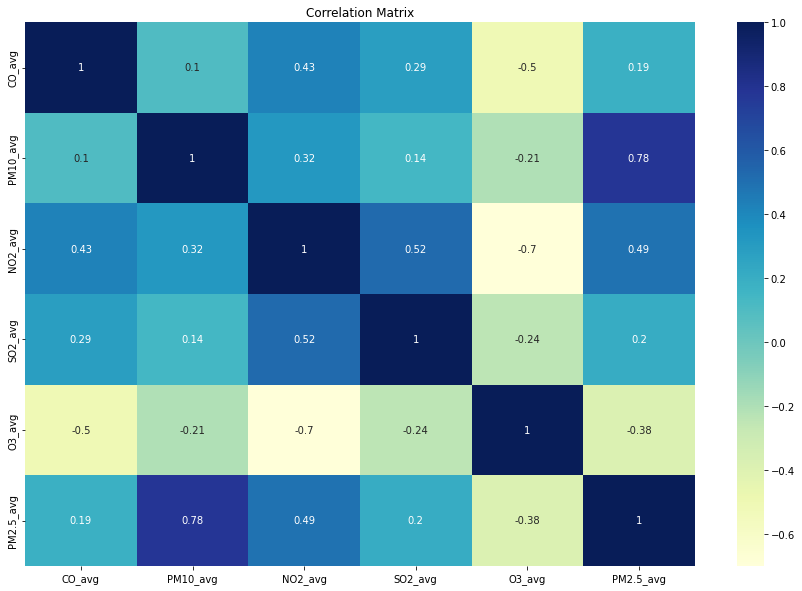

In [38]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(df_aqi_daily[cols_pollutant].corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

For pair distributions we can see different forms for O3. This is explained by natural origin of ozone. For PM10 and PM2.5 there is strong correlation with target. Most likely that particular matters correlate with weather (Spain is hot country) and CO, NO2, and SO2 related to car traffic. 

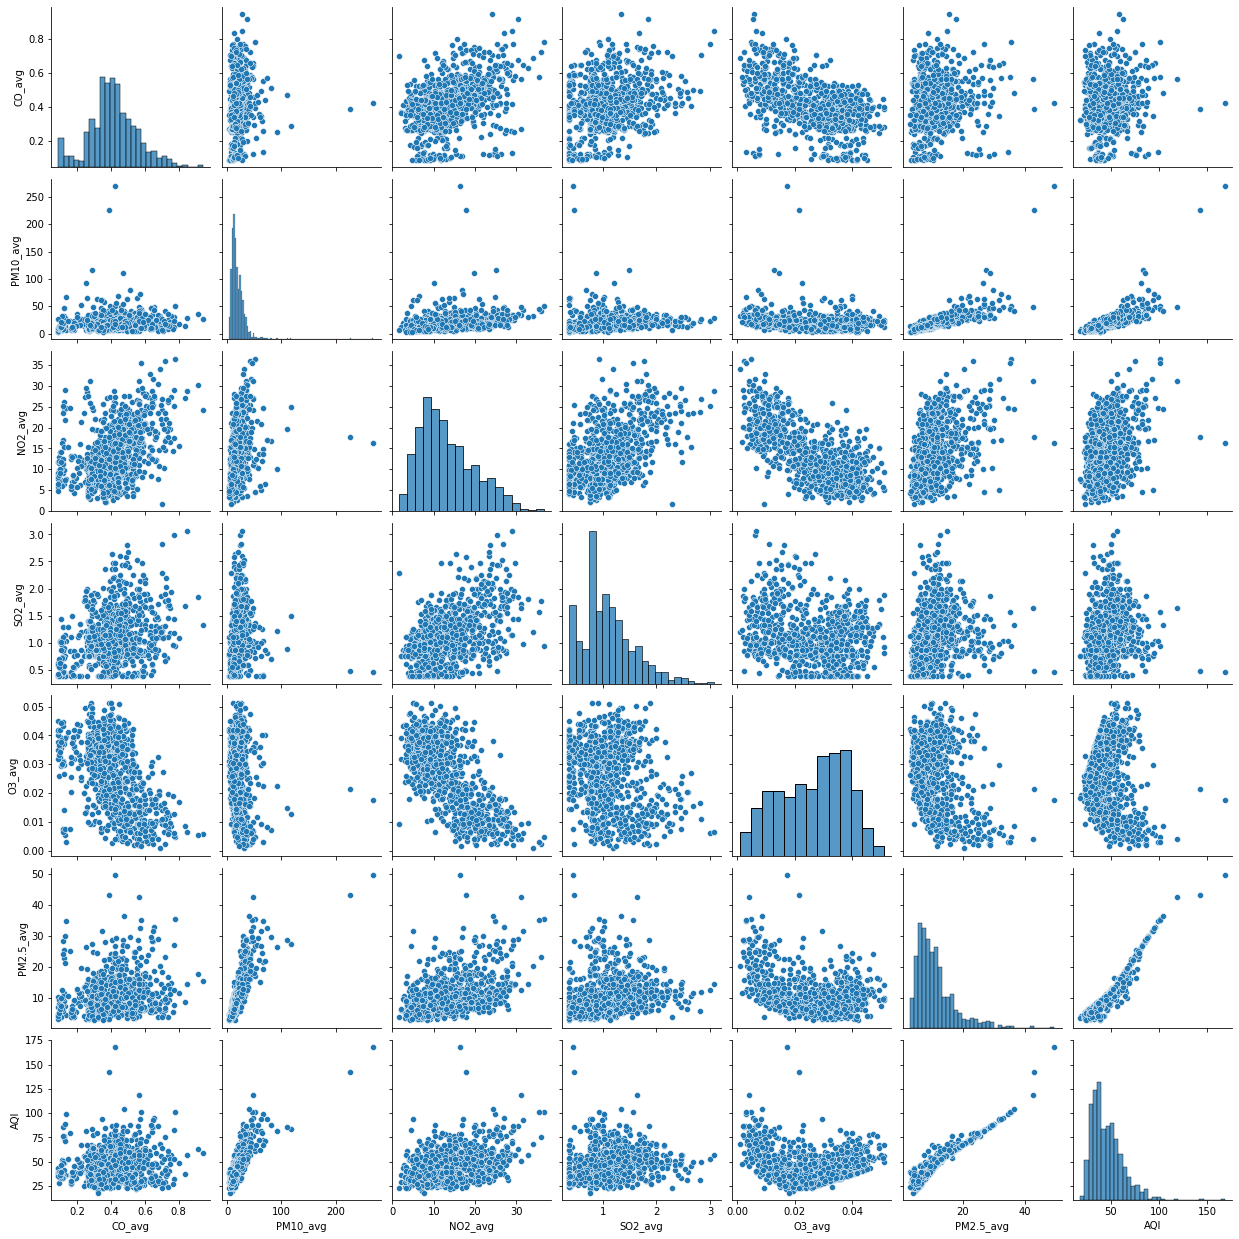

In [39]:
sns.pairplot(df_aqi_daily[cols_pollutant + col_aqi])

For forest models we can use several day before target day, because of weekly seasonality it is wise to choose 7 days, but let's check how many days we can use.

In [210]:
error_dict_pollutant = choose_day_number(cols_pollutant, df_aqi_daily, n, RandomForestRegressor(random_state=0))

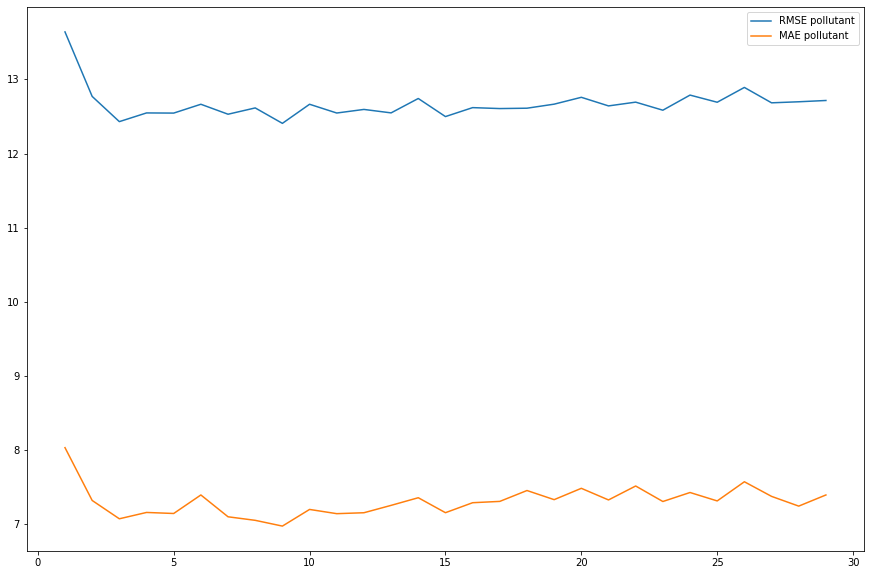

In [212]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i for i in range(1, n)], error_dict_pollutant["rmse"], label="RMSE pollutant")
plt.plot([i for i in range(1, n)], error_dict_pollutant["mae"], label="MAE pollutant")
plt.legend()
plt.show()

Looks like that it doesn't matter we use 3 or 7 days for training.

Now we will be use this dataset for search hyperparameters

In [8]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 15)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 15)]
max_depth.append(None)
min_samples_split = [2, 5, 8, 10]
min_samples_leaf = [2, 4, 6, 8]
bootstrap = [False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
depth = 7
best_rf = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, random_grid, RandomForestRegressor(random_state=0))
rf_prediction, rmse_rf, mae_rf = predict_best_model(df_aqi_daily, cols_pollutant, depth, RandomForestRegressor(random_state=0, **best_rf.best_params_))
print("Test RMSE: %.3f" % rmse_rf, "\nTest MAE: %.3f" % mae_rf)

Test RMSE: 14.113 
Test MAE: 8.788


In [18]:
depth = 5
best_rf = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, random_grid, RandomForestRegressor(random_state=0))
best_rf.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 8,
 'max_depth': 31,
 'bootstrap': False}

In [19]:
rf_prediction, rmse_rf, mae_rf = predict_best_model(df_aqi_daily, cols_pollutant, depth, RandomForestRegressor(random_state=0, **best_rf.best_params_))
print("Test RMSE: %.3f" % rmse_rf, "\nTest MAE: %.3f" % mae_rf)

Test RMSE: 13.746 
Test MAE: 8.405


In [12]:
X_train, X_test, y_train, y_test = create_x_y_datasets(df_aqi_daily, cols_pollutant, depth)

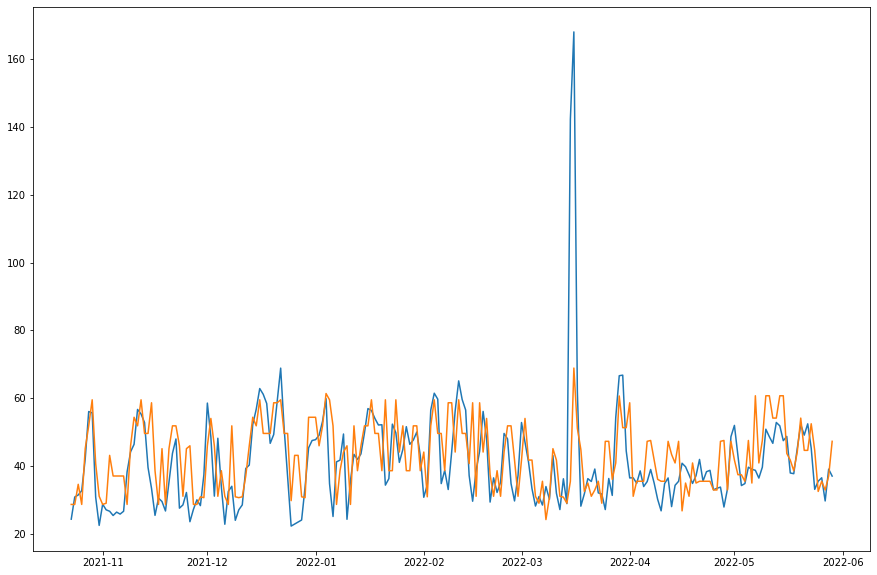

In [20]:
fig = plt.figure(figsize=(15, 10))
plt.plot(y_test)
plt.plot(y_test.index, rf_prediction)
plt.show()

For sure that testset isn't different we check train and test distributions.

<AxesSubplot:xlabel='AQI', ylabel='Count'>

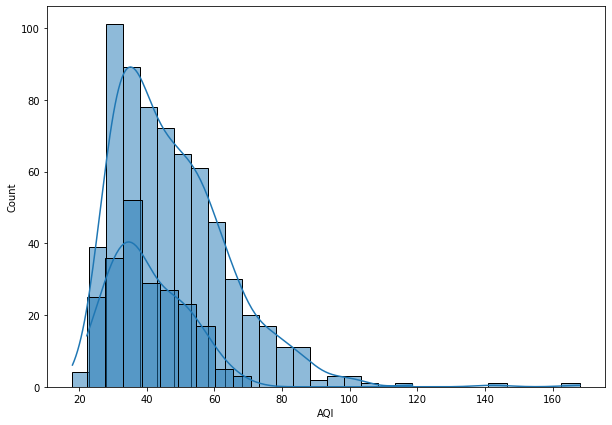

In [16]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(y_train, kde=True)
sns.histplot(y_test, kde=True)

### ***SVR***

One more model that is used for time series is SVR

In [21]:
param_grid_svr = [
    {
        'kernel': ['rbf','poly'],
        'C': np.linspace(0.01, 1000, 20),
        'gamma': np.linspace(0.001, 1, 10),
        'degree': np.linspace(1, 1, 5)
    },
    {
        'kernel': ['linear','sigmoid'],
        'C': np.linspace(0.01, 1000, 20)
    }
]

best_svr = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, param_grid_svr, SVR(epsilon = 0.1))
best_svr.best_params_

{'kernel': 'poly', 'gamma': 1.0, 'degree': 1.0, 'C': 1000.0}

In [22]:
svr_prediction, rmse_svr, mae_svr = predict_best_model(df_aqi_daily, cols_pollutant, depth, SVR(epsilon = 0.1, **best_svr.best_params_))
print("Test RMSE: %.3f" % rmse_svr, "\nTest MAE: %.3f" % mae_svr)

Test RMSE: 12.720 
Test MAE: 6.941


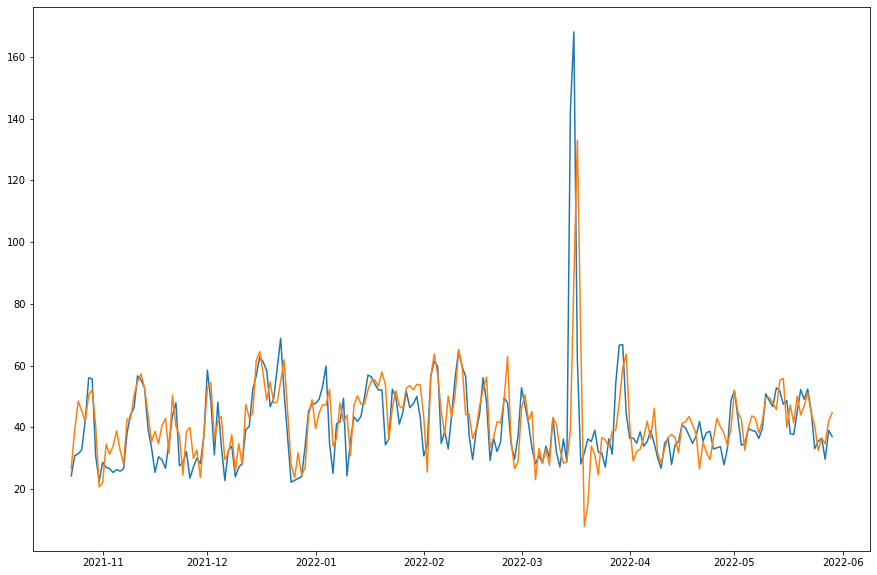

In [23]:
fig = plt.figure(figsize=(15, 10))
plt.plot(y_test)
plt.plot(y_test.index, svr_prediction)
plt.show()

### ***XGBRegressor***

In [24]:
cols_pollutant = ['CO_avg', 'PM10_avg', 'NO2_avg', 'SO2_avg', 'O3_avg', 'PM2.5_avg']
error_xgb_pollutant = choose_day_number(cols_pollutant, df_aqi_daily, n, XGBRegressor(random_state=0))

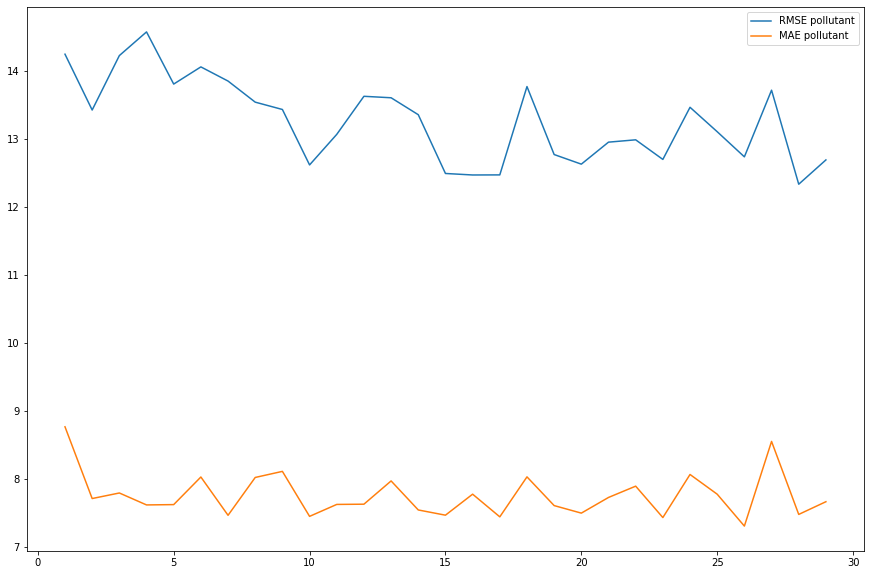

In [25]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i for i in range(1, n)], error_xgb_pollutant["rmse"], label="RMSE pollutant")
plt.plot([i for i in range(1, n)], error_xgb_pollutant["mae"], label="MAE pollutant")
plt.legend()
plt.show()

In [26]:
params_xgb = {
    'n_estimators':[100, 500, 1000],
    'min_child_weight':[4,5],
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2, 3, 4, 6, 7, 10, 15],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}

In [27]:
depth = 7
best_random_xgb = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, params_xgb, XGBRegressor(random_state=0, verbosity = 0))
best_random_xgb.best_params_

{'subsample': 0.8,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'colsample_bytree': 1.0,
 'booster': 'gblinear'}

In [28]:
depth = 7
xgb_prediction, rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 10.937 
Test MAE: 6.830


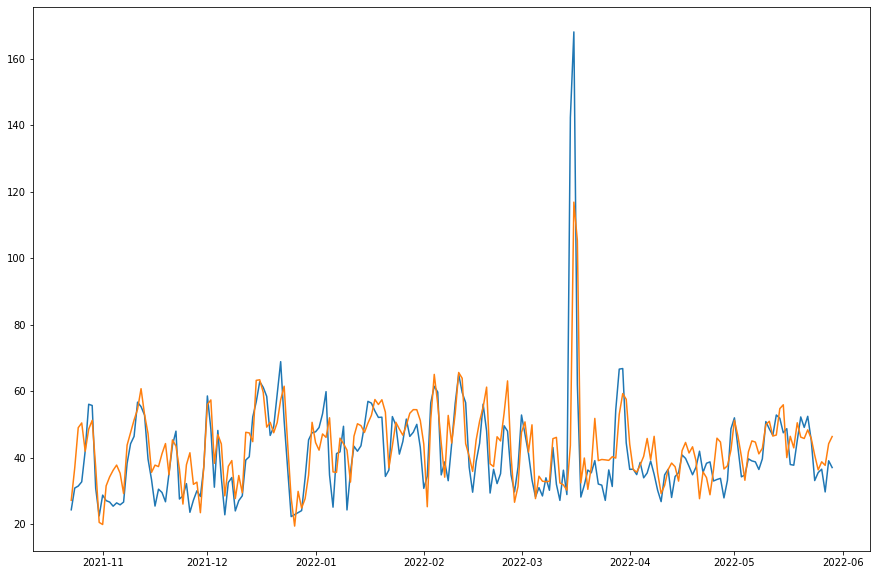

In [29]:
fig = plt.figure(figsize=(15, 10))
plt.plot(y_test)
plt.plot(y_test.index, xgb_prediction)
plt.show()

In conclusion we can say that nature of Air Quality Index time series is not linear. Linear model shows not very good results, SVR gives better score, as usual, XGBoost is the best.

Because of man-made cause of pollutats (most of them), we can add car traffic in features and weather information. When I find free data, which has long historical and updated information, I will use it for improving current model.